<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 8: Naive Bayes

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Part 1: Text Classification

We will now do a quick detour to talk about an important application area of machine learning: text classification. 

Afterwards, we will see how text classification motivates new classification algorithms.

# Review: Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depnding on the targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Classification__: The target variable $y$ is discrete and takes on one of $K$ possible values:  $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. Each discrete value corresponds to a *class* that we want to predict.

# Text Classification

An interesting instance of a classification problem is classifying text.
* Includes a lot applied problems: spam filtering, fraud detection, medical record classification, etc.
* Inputs $x$ are sequences of words of an arbitrary length.
* The dimensionality of text inputs is usually very large, proportional to the size of the vocabulary.

# Classification Dataset: Twenty Newsgroups

To illustrate the text classification problem, we will use a popular dataset called `20-newsgroups`. 
* It contains ~20,000 documents collected approximately evenly from 20 different online newsgroups.
* Each newgroup covers a different topic such as medicine, computer graphics, or religion.
* This dataset is widely used to benchmark text classification and other types of algorithms.

Let's load this dataset.

In [1]:
#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# for this lecture, we will restrict our attention to just 4 different newsgroups:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

# load the dataset
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

# print some information on it
print(twenty_train.DESCR[:1100])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [2]:
# The set of targets in this dataset are the newgroup topics:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [3]:
# Let's examine one data point
print(twenty_train.data[3])

From: s0612596@let.rug.nl (M.M. Zwart)
Subject: catholic church poland
Organization: Faculteit der Letteren, Rijksuniversiteit Groningen, NL
Lines: 10

Hello,

I'm writing a paper on the role of the catholic church in Poland after 1989. 
Can anyone tell me more about this, or fill me in on recent books/articles(
in english, german or french). Most important for me is the role of the 
church concerning the abortion-law, religious education at schools,
birth-control and the relation church-state(government). Thanx,

                                                 Masja,
"M.M.Zwart"<s0612596@let.rug.nl>



In [4]:
# We have about 2k data points in total
print(len(twenty_train.data))

2257


# Feature Representations for Text

Each data point $x$ in this dataset is a squence of characters of an arbitrary length.

How do we transform these into $d$-dimensional features $\phi(x)$ that can be used with our machine learning algorithms?

* We may devise hand-crafted features by inspecting the data:
    * Does the message contain the word "church"? Does the email of the user originate outside the United States? Is the organization a university? etc. 

* We can count the number of occurrences of each word:
    * Does this message contain "Aardvark", yes or no?
    * Does this message contain "Apple", yes or no?
    * ... Does this message contain "Zebra", yes or no?

* Finally, many modern deep learning methods can directly work with sequences of characters of an arbitrary length.

# Bag of Words Representations

Perhaps the most widely used approach to representing text documents is called "bag of words".

We start by defining a vocabulary $V$ containing all the possible words we are interested in, e.g.:
$$ V = \{\text{church}, \text{doctor}, \text{fervently}, \text{purple}, \text{slow}, ...\} $$

A bag of words representation of a document $x$ is a function $\phi(x) \to \{0,1\}^{|V|}$ that outputs a feature vector
$$
\phi(x) = \left( 
\begin{array}{c}
0 \\
1 \\
0 \\
\vdots \\
0 \\
\vdots \\
\end{array}
\right)
\begin{array}{l}
\;\text{church} \\
\;\text{doctor} \\
\;\text{fervently} \\
\\
\;\text{purple} \\
\\
\end{array}
$$
of dimension $V$. The $j$-th component $\phi(x)_j$ equals $1$ if $x$ convains the $j$-th word in $V$ and $0$ otherwise.

Let's see an example of this approach on `20-newsgroups`.

We start by computing these features using the `sklearn` library.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorize the training set
count_vect = CountVectorizer(binary=True)
X_train = count_vect.fit_transform(twenty_train.data)
X_train.shape

(2257, 35788)

In `sklearn`, we can retrieve the index of $\phi(x)$ associated with each `word` using the expression `count_vect.vocabulary_.get(word)`:

In [6]:
# The CountVectorizer class records the index j associated with each word in V
print('Index for the word "church": ', count_vect.vocabulary_.get(u'church'))
print('Index for the word "computer": ', count_vect.vocabulary_.get(u'computer'))

Index for the word "church":  8609
Index for the word "computer":  9338


Our featurized dataset is in the matrix `X_train`. We can use the above indices to retrieve the 0-1 value that has been computed for each word:

In [7]:
# We can examine if any of these words are present in our previous datapoint
print(twenty_train.data[3])

# let's see if it contains these two words?
print('---'*20)
print('Value at the index for the word "church": ', X_train[3, count_vect.vocabulary_.get(u'church')])
print('Value at the index for the word "computer": ', X_train[3, count_vect.vocabulary_.get(u'computer')])
print('Value at the index for the word "doctor": ', X_train[3, count_vect.vocabulary_.get(u'doctor')])
print('Value at the index for the word "important": ', X_train[3, count_vect.vocabulary_.get(u'important')])

From: s0612596@let.rug.nl (M.M. Zwart)
Subject: catholic church poland
Organization: Faculteit der Letteren, Rijksuniversiteit Groningen, NL
Lines: 10

Hello,

I'm writing a paper on the role of the catholic church in Poland after 1989. 
Can anyone tell me more about this, or fill me in on recent books/articles(
in english, german or french). Most important for me is the role of the 
church concerning the abortion-law, religious education at schools,
birth-control and the relation church-state(government). Thanx,

                                                 Masja,
"M.M.Zwart"<s0612596@let.rug.nl>

------------------------------------------------------------
Value at the index for the word "church":  1
Value at the index for the word "computer":  0
Value at the index for the word "doctor":  0
Value at the index for the word "important":  1


# Practical Considerations

In practice, we may use some additional modifications of this techinque:

* Sometimes, the feature $\phi(x)_j$ for the $j$-th word holds the count of occurrences of word $j$ instead of just the binary occurrence.

* The raw text is usually preprocessed. One common technique is *stemming*, in which we only keep the root of the word.
    * e.g. "slowly", "slowness", both map to "slow"

* Filtering for common *stopwords* such as "the", "a", "and". Similarly, rare words are also typically excluded.

# Classification Using BoW Features

Let's now have a look at the performance of classification over bag of words features.

Now that we have a feature representation $\phi(x)$, we can apply the classifier of our choice, such as logistic regression.

In [8]:
from sklearn.linear_model import LogisticRegression

# Create an instance of Softmax and fit the data.
logreg = LogisticRegression(C=1e5, multi_class='multinomial', verbose=True)
logreg.fit(X_train, twenty_train.target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


LogisticRegression(C=100000.0, multi_class='multinomial', verbose=True)

And now we can use this model for predicting on new inputs.

In [9]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']

X_new = count_vect.transform(docs_new)
predicted = logreg.predict(X_new)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


# Summary of Text Classification

* Classifying text normally requires specifiyng features over the raw data.
* A widely used representation is "bag of words", in which features are occurrences or counts of words.

* Once text is featurized, any off-the-shelf supervised learning algorithm can be applied, but some work better than others, as we will see next.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Naive Bayes

Next, we are going to look at Naive Bayes --- a generative classification algorithm. We will apply Naive Bayes to the text classification problem.


# Review: Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depnding on the targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Classification__: The target variable $y$ is discrete and takes on one of $K$ possible values:  $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. Each discrete value corresponds to a *class* that we want to predict.

# Review: Text Classification

An interesting instance of a classification problem is classifying text.
* Includes a lot applied problems: spam filtering, fraud detection, medical record classification, etc.
* Inputs $x$ are sequences of words of an arbitrary length.
* The dimensionality of text inputs is usually very large, proportional to the size of the vocabulary.

# Review: Bag of Words Features

Given a vocabulary $V$, a bag of words representation of a document $x$ is a function $\phi(x) \to \{0,1\}^{|V|}$ that outputs a feature vector
$$
\phi(x) = \left( 
\begin{array}{c}
0 \\
1 \\
0 \\
\vdots \\
0 \\
\vdots \\
\end{array}
\right)
\begin{array}{l}
\;\text{church} \\
\;\text{doctor} \\
\;\text{fervently} \\
\\
\;\text{purple} \\
\\
\end{array}
$$
of dimension $|V|$. The $j$-th component $\phi(x)_j$ equals $1$ if $x$ convains the $j$-th word in $V$ and $0$ otherwise.

# Review: Generative Models

There are two types of probabilistic models: *generative* and *discriminative*.
\begin{align*}
\underbrace{P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{generative model} & \;\; & \underbrace{P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{discriminative model}
\end{align*}

Given a new datapoint $x'$, we can match it against each class model and find the class that looks most similar to it:
\begin{align*}
\arg \max_y \log p(y | x) = \arg \max_y \log \frac{p(x | y) p(y)}{p(x)} = \arg \max_y \log p(x | y) p(y),
\end{align*}
where we have applied Bayes' rule in the second equation.

# Review: Gaussian Discriminant Model

The GDA algorithm defines the following model family.
* The probability $P(x\mid y=k)$ of the data under class $k$ is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) $\mathcal{N}(x; \mu_k, \Sigma_k)$ with parameters
$\mu_k, \Sigma_k$.
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.

Thus, $P_\theta(x,y)$ is a mixture of $K$ Gaussians:
$$P_\theta(x,y) = \sum_{k=1}^K P_\theta(y=k) P_\theta(x|y=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

# Problem 1: Discrete Data

What would happen if we used GDA to perform text classification?
The first problem we face is that the input data is discrete:
$$
\phi(x) = \left( 
\begin{array}{c}
0 \\
1 \\
0 \\
\vdots \\
0 \\
\vdots \\
\end{array}
\right)
\begin{array}{l}
\;\text{church} \\
\;\text{doctor} \\
\;\text{fervently} \\
\\
\;\text{purple} \\
\\
\end{array}
$$
This data does not follows a Normal distribution, hence the GDA model is clearly misspecified.

# Problem 2: High Dimensionality

A first solution is to assume that $x$ is sampled from a categorical distribution that assigns a probability to each possible state of $x$.
$$
p(x) = p \left( 
\begin{array}{c}
0 \\
1 \\
0 \\
\vdots \\
0 
\end{array}
\right.
\left.
\begin{array}{l}
\;\text{church} \\
\;\text{doctor} \\
\;\text{fervently} \\
\vdots \\
\;\text{purple}
\end{array}
\right) = 0.0012
$$

However, if the dimensionality $d$ of $x$ is high (e.g., vocabulary has size 10,000), $x$ can take a huge number of values ($2^{10000}$ in our example). We need to specify $2^{d}-1$ parameters for the categorical distribution.

# Naive Bayes Assumption

In order to deal with high-dimensional $x$, we simplify the problem by making the *Naive Bayes* assumption:
$$ p(x|y) = \prod_{j=1}^d p(x_j \mid y) $$
In other words, the probability $p(x|y)$ factorizes over each dimension.

* For example, if $x$ is a binary bag of words representation, then $p(x_j | y)$ is the probability of seeing the $j$-th word.

* We can model each $p(x_j | y)$ via a Bernoulli distribution, which has only one parameter. 

* Hence, it takes only $d$ parameters (instead of $2^d-1$) to specify the entire distribution $p(x|y) = \prod_{j=1}^d p(x_j \mid y)$.

# Bernoulli Naive Bayes Model

We can apply the Naive Bayes assumption to obtain a model for when $x$ is in a bag of words representation.

The *Bernoulli Naive Bayes* model $P_\theta(x,y)$ is defined as follows:
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.
* The conditional probability of the data under class $k$ factorizes as $P_\theta(x|y=k) = \prod_{j=1}^d P(x_j \mid y=k)$ (the Naive Bayes assumption), where each $P_\theta(x_j \mid y=k)$ is a $\text{Bernoullli}(\psi_{jk})$.

Formally, we have:
\begin{align*}
P_\theta(y) & = \text{Categorical}(\phi_1,\phi_2,\ldots,\phi_K) \\
P_\theta(x_j=1|y=k) & = \text{Bernoullli}(\psi_{jk}) \\
P_\theta(x|y=k) & = \prod_{j=1}^d P_\theta(x_j|y=k)
\end{align*}

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Naive Bayes: Learning

We are going to continue our discussion of Naive Bayes.

We will now turn our attention to learnig the parameters of the model and using them to make predictions.

# Review: Text Classification

An interesting instance of a classification problem is classifying text.
* Includes a lot applied problems: spam filtering, fraud detection, medical record classification, etc.
* Inputs $x$ are sequences of words of an arbitrary length.
* The dimensionality of text inputs is usually very large, proportional to the size of the vocabulary.

# Review: Bag of Words Features

Given a vocabulary $V$, a bag of words representation of a document $x$ is a function $\phi(x) \to \{0,1\}^{|V|}$ that outputs a feature vector
$$
\phi(x) = \left( 
\begin{array}{c}
0 \\
1 \\
0 \\
\vdots \\
0 \\
\vdots \\
\end{array}
\right)
\begin{array}{l}
\;\text{church} \\
\;\text{doctor} \\
\;\text{fervently} \\
\\
\;\text{purple} \\
\\
\end{array}
$$
of dimension $|V|$. The $j$-th component $\phi(x)_j$ equals $1$ if $x$ convains the $j$-th word in $V$ and $0$ otherwise.

# Bernoulli Naive Bayes Model

The *Bernoulli Naive Bayes* model $P_\theta(x,y)$ is defined as follows:
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.
* The conditional probability of the data under class $k$ factorizes as $P_\theta(x|y=k) = \prod_{j=1}^d P(x_j \mid y=k)$ (the Naive Bayes assumption), where each $P_\theta(x_j \mid y=k)$ is a $\text{Bernoullli}(\psi_{jk})$.

# Review: Maximum Likelihood Learning

In order to fit probabilistic models, we use the following objective:
$$ \max_\theta \mathbb{E}_{x, y \sim \mathbb{P}_\text{data}} \log P_\theta(x, y). $$
This seeks to find a model that assigns high probability to the training data.

Let's use maximum likelihood to fit the Bernoulli Naive Bayes model. Note that model parameterss $\theta$ are the union of the parameters of each sub-model:
$$\theta = (\phi_1, \phi_2,\ldots, \phi_K, \psi_{11}, \psi_{21}, \ldots, \psi_{dK}).$$


# Learning a Bernoulli Naive Bayes Model

Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\mid i=1,2,\ldots,n\}$, we want to optimize the log-likelihood $\ell(\theta) = \log L(\theta)$:
\begin{align*}
\ell(\theta) & = \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)}) = \sum_{i=1}^n \log P_\theta(x^{(i)} | y^{(i)}) + \sum_{i=1}^n \log P_\theta(y^{(i)}) \\
& = \sum_{k=1}^K \sum_{j=1}^d \underbrace{\sum_{i :y^{(i)} =k} \log P(x^{(i)}_j | y^{(i)} ; \psi_{jk})}_\text{all the terms that involve $\psi_{jk}$} + \underbrace{\sum_{i=1}^n \log P(y^{(i)} ; \vec \phi)}_\text{all the terms that involve $\vec \phi$}.
\end{align*}

Notice that each parameter $\psi_{jk}$ is found in only one subset of terms and the $\phi_k$ are also in the same set of terms.

As in Gaussian Discriminant Analysis, the log-likelihood decomposes into a sum of terms. To optimize for some $\psi_{jk}$, we only need to look at the set of terms that contain $\psi_{jk}$:
$$ \arg\max_{\psi_{jk}} \ell(\theta) = \arg\max_{\psi_{jk}} \sum_{i :y^{(i)} =k} \log p(x^{(i)}_j | y^{(i)} ; \psi_{jk}). $$

Similarly, optimizing for $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$ only involves a single term:
$$ \max_{\vec \phi} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)} ; \theta) = \max_{\vec\phi} \sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi). $$

# Optimizing the Model Parameters

These observations greatly simplify the optimization of the model. Let's first consider the optimization over $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$. 

As in Gaussian Discriminant Analysis, we can take a derivative over $\phi_k$ and set it to zero to obtain 
$$ \phi_k = \frac{n_k}{n}$$
for each $k$, where $n_k = |\{i : y^{(i)} = k\}|$ is the number of training targets with class $k$.

Thus, the optimal $\phi_k$ is just the proportion of data points with class $k$ in the training set!

Similarly, we can maximize the likelihood for the other parameters to obtain closed form solutions:
\begin{align*}
\psi_{jk} = \frac{n_{jk}}{n_k}.
\end{align*}
where $|\{i : x^{(i)}_j = 1 \text{ and } y^{(i)} = k\}|$ is the number of $x^{(i)}$ with label $k$ and a positive occurrence of word $j$.

Each $\psi_{jk}$ is simply the proportion of documents in class $k$ that contain the word $j$.

# Querying the Model

How do we ask the model for predictions? As discussed earler, we can apply Bayes' rule:
$$\arg\max_y P_\theta(y|x) = \arg\max_y P_\theta(x|y)P(y).$$
Thus, we can estimate the probability of $x$ and under each $P_\theta(x|y=k)P(y=k)$ and choose the class that explains the data best.

# Classification Dataset: Twenty Newsgroups

To illustrate the text classification problem, we will use a popular dataset called `20-newsgroups`. 
* It contains ~20,000 documents collected approximately evenly from 20 different online newsgroups.
* Each newgroup covers a different topic such as medicine, computer graphics, or religion.
* This dataset is widely used to benchmark text classification and other types of algorithms.

Let's load this dataset.

In [10]:
#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# for this lecture, we will restrict our attention to just 4 different newsgroups:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

# load the dataset
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

# print some information on it
print(twenty_train.DESCR[:1100])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

# Example: Text Classification

Let's see how this approach can be used in practice on the text classification dataset.
* We will learn a good set of parameters for a Bernoulli Naive Bayes model
* We will compare the outputs to the true predictions.

Let's see an example of this approach on `20-newsgroups`.

We start by computing these features using the `sklearn` library.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorize the training set
count_vect = CountVectorizer(binary=True, max_features=1000)
y_train = twenty_train.target
X_train = count_vect.fit_transform(twenty_train.data).toarray()
X_train.shape

(2257, 1000)

Let's compute the maximum likelihood model parameters on our dataset.

In [12]:
# we can implement these formulas over the Iris dataset
n = X_train.shape[0] # size of the dataset
d = X_train.shape[1] # number of features in our dataset
K = 4 # number of clases

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K):
    X_k = X_train[y_train == k]
    psis[k] = np.mean(X_k, axis=0)
    phis[k] = X_k.shape[0] / float(n)

# print out the class proportions
print(phis)

[0.21267169 0.25875055 0.26318121 0.26539654]


We can compute predictions using Bayes' rule.

In [13]:
# we can implement this in numpy
def nb_predictions(x, psis, phis):
    """This returns class assignments and scores under the NB model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d))
    psis = np.reshape(psis, (K, 1, d))
    
    # clip probabilities to avoid log(0)
    psis = psis.clip(1e-14, 1-1e-14)
    
    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

idx, logpyx = nb_predictions(X_train, psis, phis)
print(idx[:10])

[1 1 3 0 3 3 3 2 2 2]


We can measure the accuracy on the training set:

In [14]:
(idx==y_train).mean()

0.8692955250332299

In [15]:
docs_new = ['OpenGL on the GPU is fast']

X_new = count_vect.transform(docs_new).toarray()
predicted, logpyx_new = nb_predictions(X_new, psis, phis)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'OpenGL on the GPU is fast' => comp.graphics


# Algorithm: Bernoulli Naive Bayes

* __Type__: Supervised learning (multi-class classification)
* __Model family__: Mixtures of Bernoulli distributions
* __Objective function__: Log-likelihood.
* __Optimizer__: Closed form solution.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 4: Discriminative vs. Generative Algorithms

We conclude our lectures on generative algorithms by revisting the question of how they compare to discriminative algorithms.

# Review: Generative Models

There are two types of probabilistic models: *generative* and *discriminative*.
\begin{align*}
\underbrace{P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{generative model} & \;\; & \underbrace{P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{discriminative model}
\end{align*}

Given a new datapoint $x'$, we can match it against each class model and find the class that looks most similar to it:
\begin{align*}
\arg \max_y \log p(y | x) = \arg \max_y \log \frac{p(x | y) p(y)}{p(x)} = \arg \max_y \log p(x | y) p(y),
\end{align*}
where we have applied Bayes' rule in the second equation.

# Review: Gaussian Discriminant Model

The GDA algorithm defines the following model family.
* The probability $P(x\mid y=k)$ of the data under class $k$ is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) $\mathcal{N}(x; \mu_k, \Sigma_k)$ with parameters
$\mu_k, \Sigma_k$.
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.

Thus, $P_\theta(x,y)$ is a mixture of $K$ Gaussians:
$$P_\theta(x,y) = \sum_{k=1}^K P_\theta(y=k) P_\theta(x|y=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

# Classification Dataset: Iris Flowers

To look at properties of generative algorithms, let's look again at the Iris flower dataset. 

It's a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. Nowadays, it's widely used for demonstrating machine learning algorithms.

In [16]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


If we only consider the first two feature columns, we can visualize the dataset in 2D.

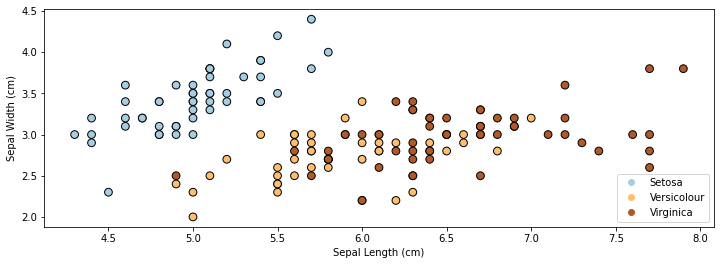

In [17]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# create 2d version of dataset
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')

# Linear Discriminant Analysis

When the covariances $\Sigma_k$ in GDA are equal, we have an algorithm called Linear Discriminant Analysis or LDA.

Let's try this algorithm on the Iris flower dataset.

We may compute the parameters of this model similarly to how we did for GDA.

In [19]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X.T) # this is now X.T instead of X_k.T
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]


We can compute predictions using Bayes' rule.

In [20]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 1 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


We visualize predictions like we did earlier.

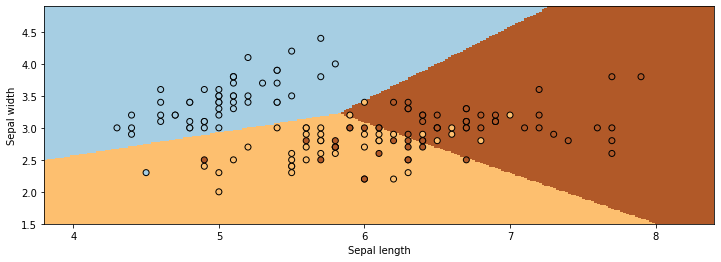

In [22]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

Linear Discriminant Analysis outputs decision boundaries that are linear.

Softmax or Logistic regression also produce linear boundaries. In fact, both types of algorithms make use of the same model class.

What is their difference then?

# Generative vs. Discriminative Model Classes

In binary classification, we can also show that the conditional probability $P_\theta(y|x)$ of a Bernoulli Naive Bayes or LDA model has the form
$$ P_\theta(y|x) = \frac{P_\theta(x|y)P_\theta(y)}{\sum_{y'\in \mathcal{Y}}P_\theta(x|y')P_\theta(y')} = \frac{1}{1+\exp(-\gamma^\top x)} $$
for some set of parameters $\gamma$ (whose expression can be derived from $\theta$), which is the same form as Logistic Regression!

Does it mean that the two sets of algorithms are equivalent? No! They assume the same model class $\mathcal{M}$, they use a different objective $J$ to select a model in $\mathcal{M}$.

# Generative Models vs. Logistic Regression

Given that both algorithms find linear boundaries, how should one choose between the two?

* Bernoulli Naive Bayes or LDA assumes a logistic form for $p(y|x)$. But converse is not true: logistic regression does not assume a NB or LDA model for $p(x,y)$.

* Generative models make stronger modeling assumptions. If these assumptions hold true, the generative models will perform better.

* But if they don't, logistic regression will be more robust to outliers and model misspecification, and achieve higher accuracy.

# Other Features of Generative Models

Generative models can also do things that discriminative models can't do.
* Generation: we can sample $x \sim p(x|y)$ to generate new data (images, audio).
* Missing value imputation: if $x_j$ is missing, we can infer it using $p(x|y)$.
* Outlier detection: given a new $x'$, we can try detecting via $p(x')$ if $x'$ is invalid.

# Discriminative Approaches

Discriminative algorithms are deservingly very popular.
* Most state-of-the-art algorithms for classification are discriminative
* They are often more accurate because they make fewer modeling assumptions.

# Generative Approaches

But generative algorithms also have many advantages:
* Can do more than just prediction: generation, fill-in missing features, etc.
* Can include extra prior knowledge; if prior knowledge is correct, model will be more accurate.
* Often have closed-form solutions, hence are faster to train.